In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm
from tensorflow.keras.layers import Lambda

from utils import *
from help import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Check devices
print("Available devices:", tf.config.list_physical_devices())

def get_pig_model():
    epsilon =1e-7
    min_max_norm = Lambda(lambda x: (x - K.min(x)) / (K.max(x) - K.min(x)+ epsilon) * (1.0) )
    
    print("model is loading")
    en = [16 ,16 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64 ,64]
    de = [64 ,64 ,64 ,64, 64 ,64 ,64, 64, 64, 16 ,16 ,2]
    input_img = Input(shape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1))
    unet_model = vxm.networks.Unet(inshape=(param_3d.img_size_192,param_3d.img_size_192,param_3d.img_size_192, 1), nb_features=(en, de),
                       nb_conv_per_level=2,
                       final_activation_function='softmax')
        
    latest_weight = max(glob.glob(os.path.join("models_gmm", 'weights_epoch_*.h5')), key=os.path.getctime, default=None)
    print(latest_weight)
    generated_img_norm = min_max_norm(input_img)
    segmentation = unet_model(generated_img_norm)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    combined_model.load_weights(latest_weight)
    return combined_model

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-01-06 10:43:55.338207: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-06 10:43:55.338306: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: cubic-login1
2025-01-06 10:43:55.338348: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: cubic-login1
2025-01-06 10:43:55.338515: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2025-01-06 10:43:55.338600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-01-06 10:43:55.338619: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1


In [2]:
validation_folder_path = "/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical"
subfolders = [f.name for f in os.scandir(validation_folder_path) if f.is_dir()]
combined_model = get_pig_model()

model is loading
models_gmm/weights_epoch_820.h5


/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7646/anat/anat.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


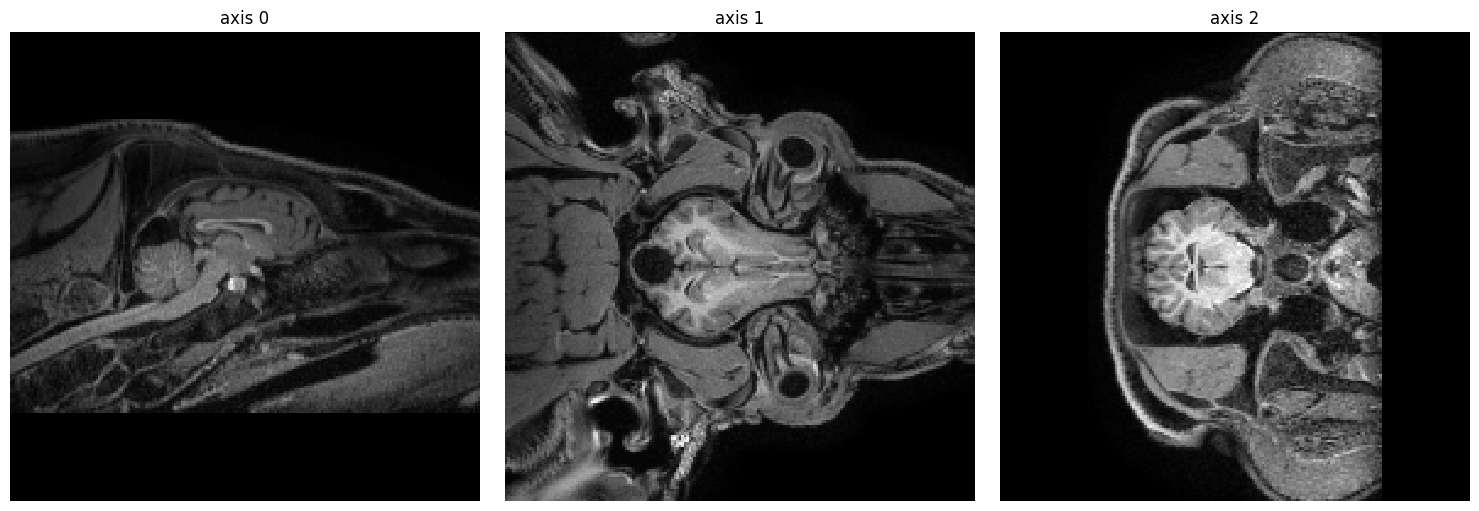

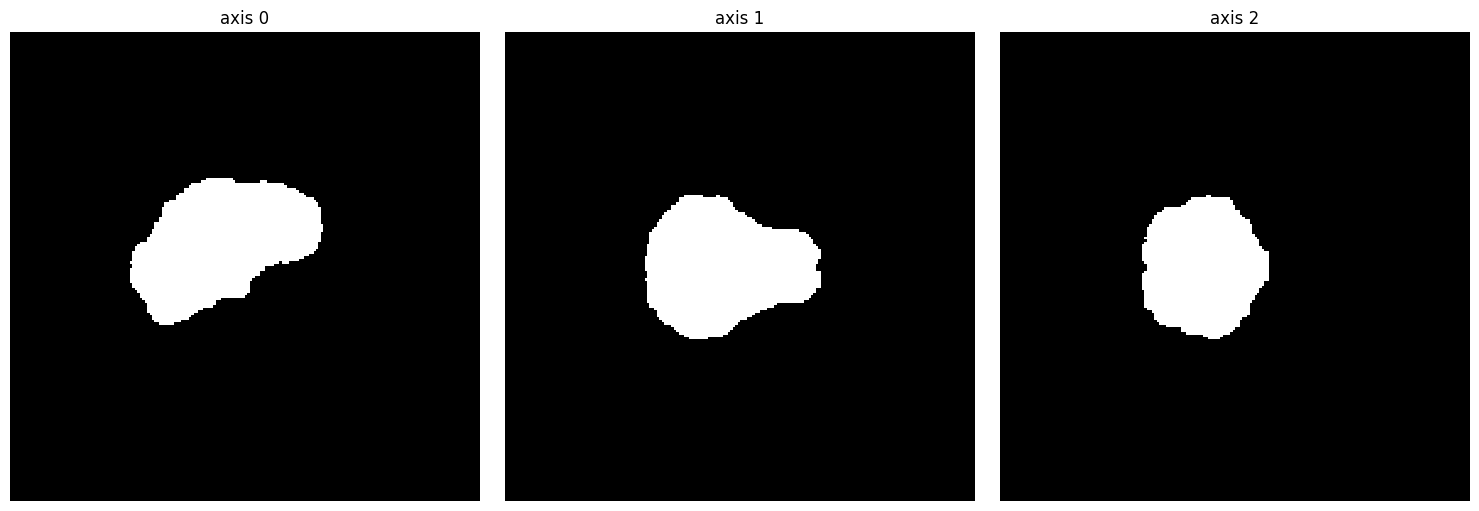

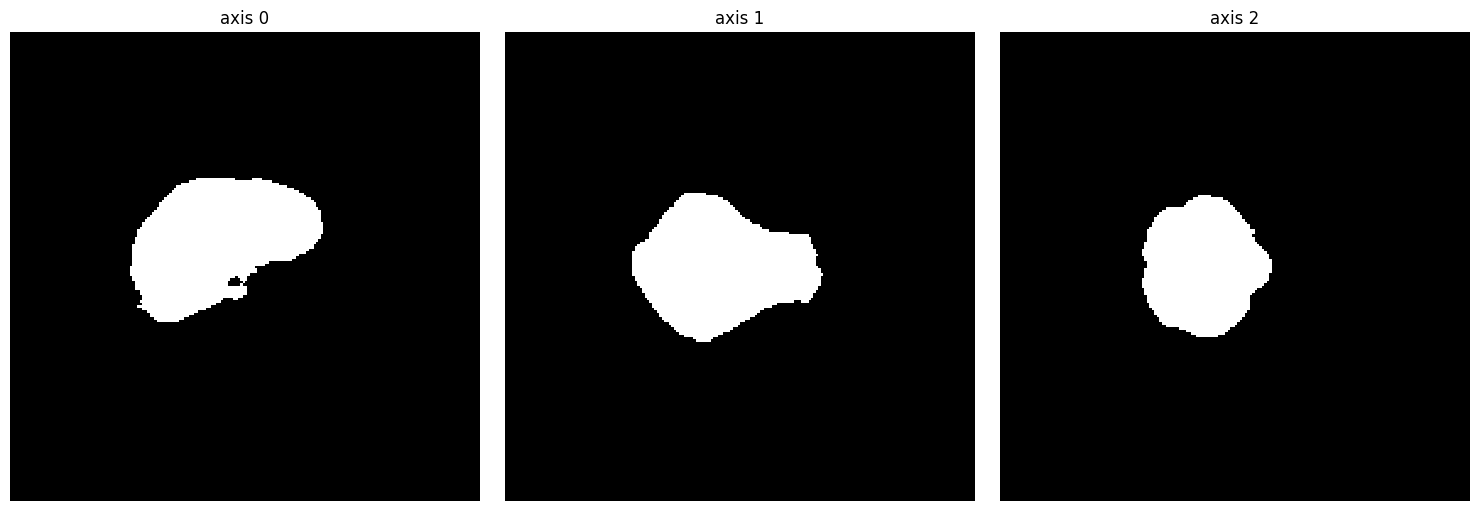

/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/8030/anat/anat.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


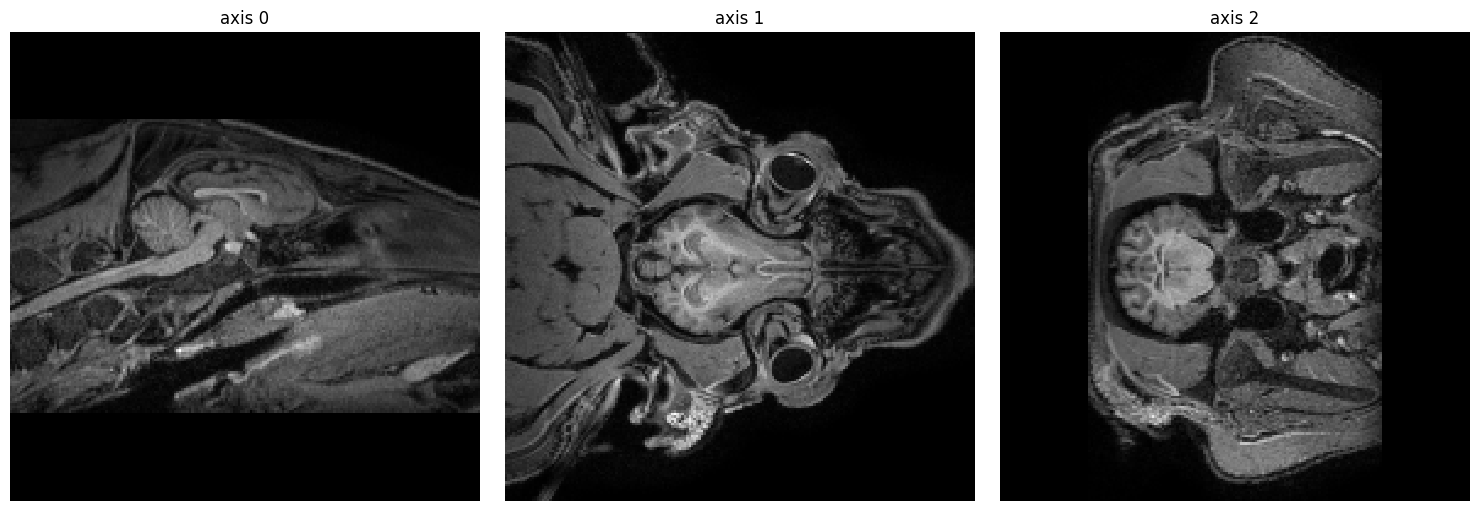

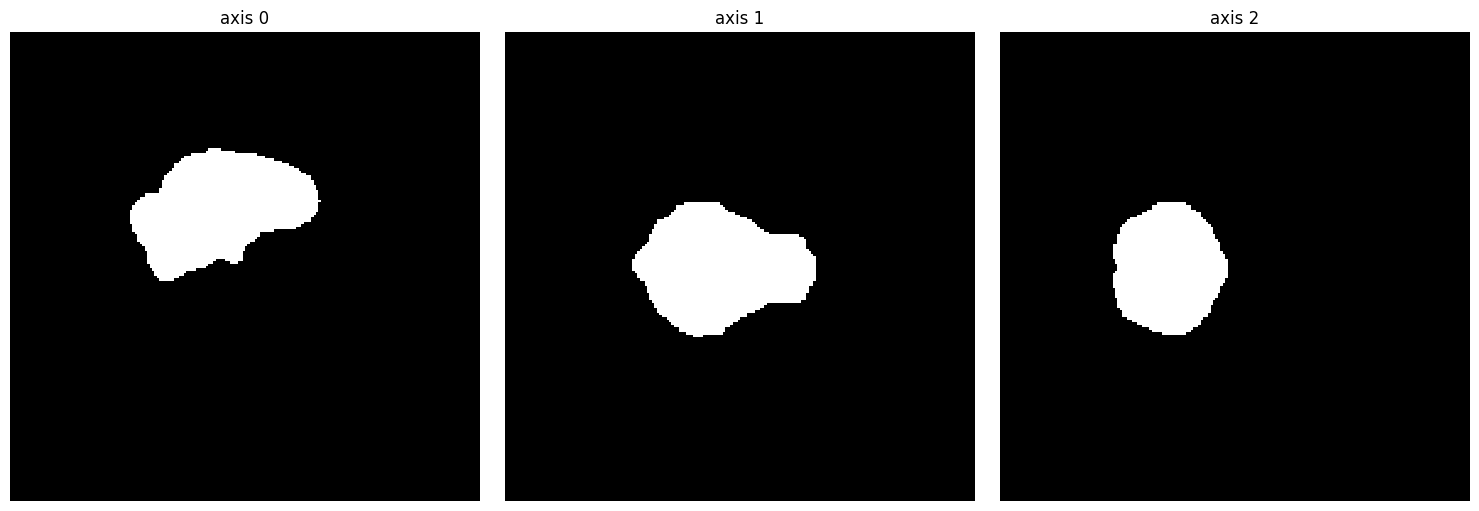

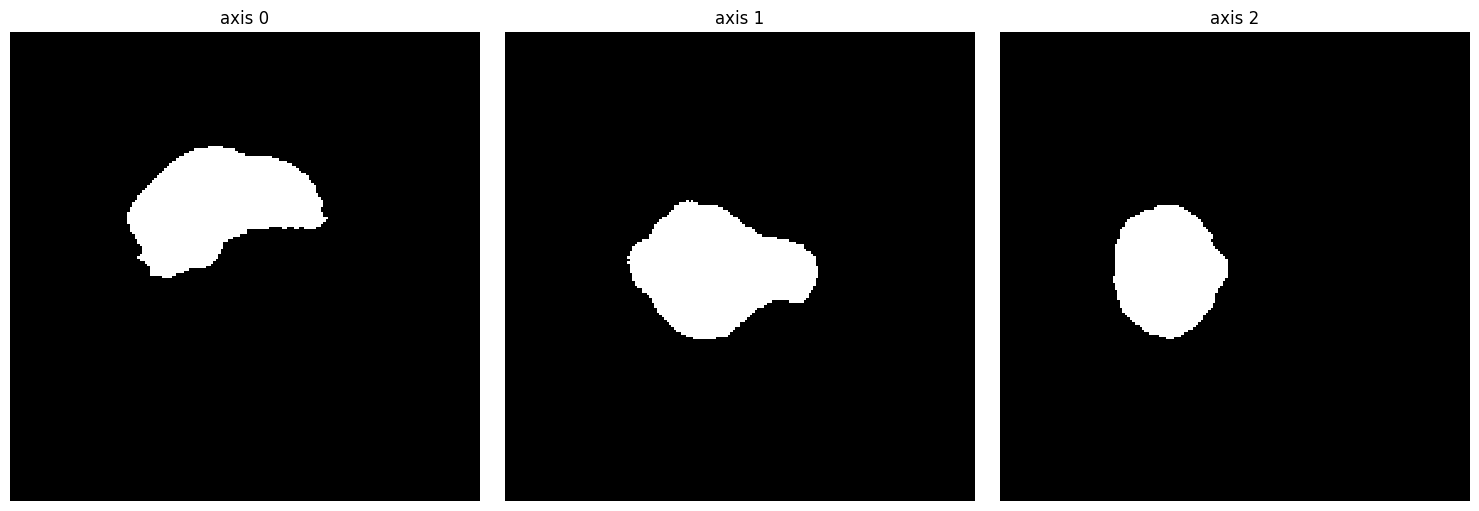

/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/8031/anat/anat.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


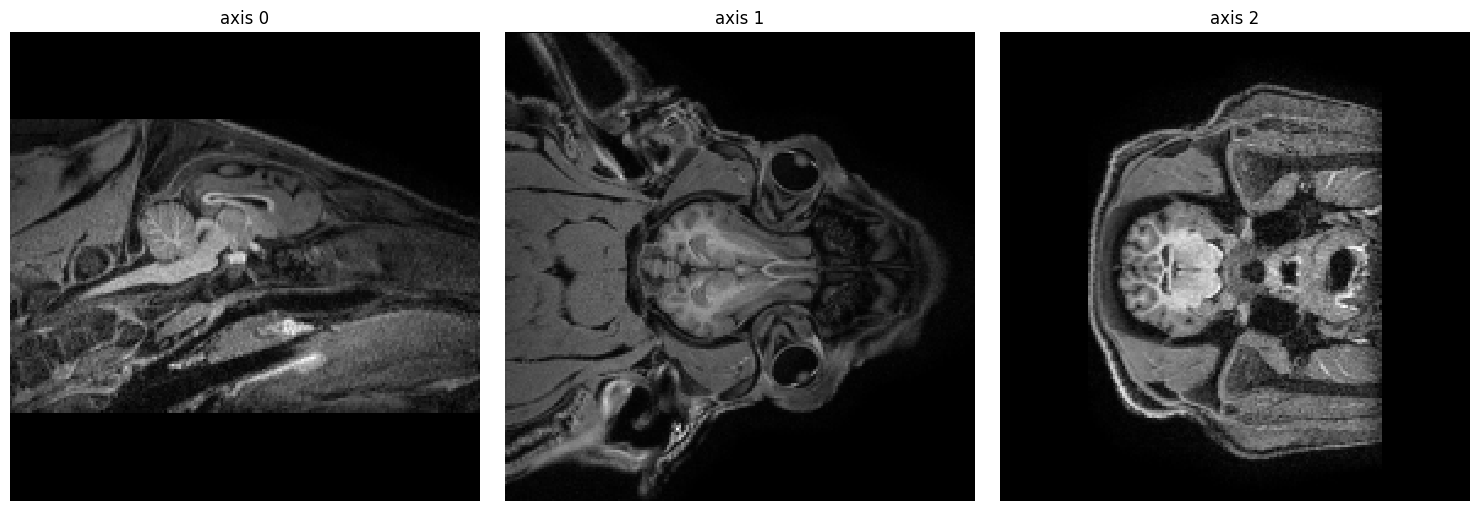

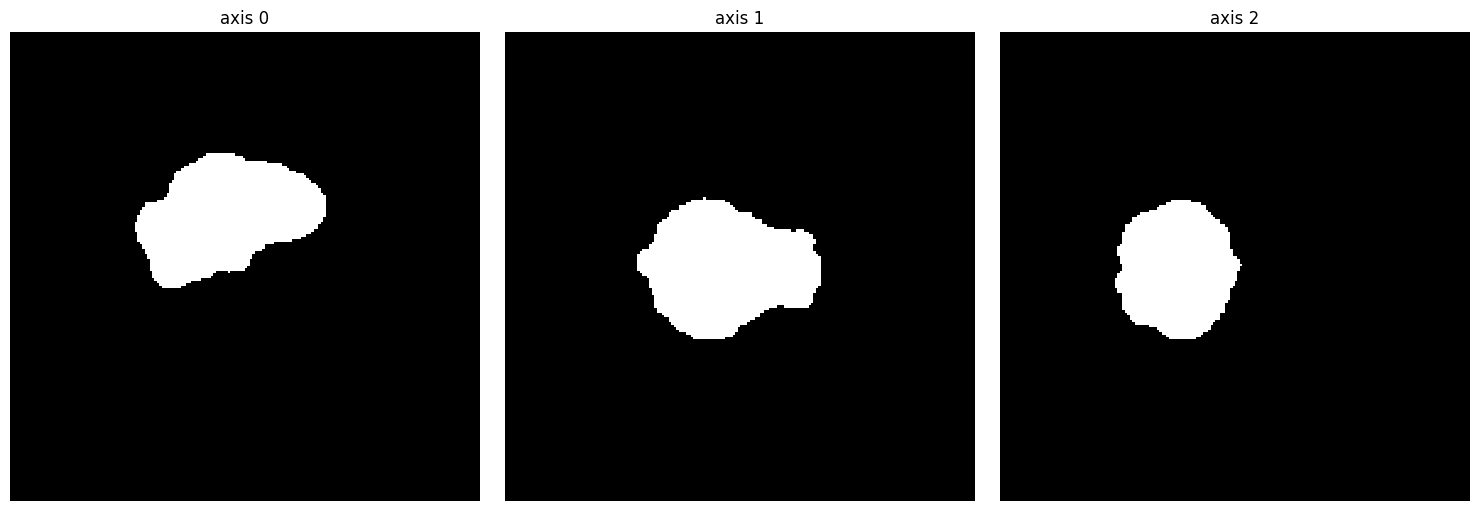

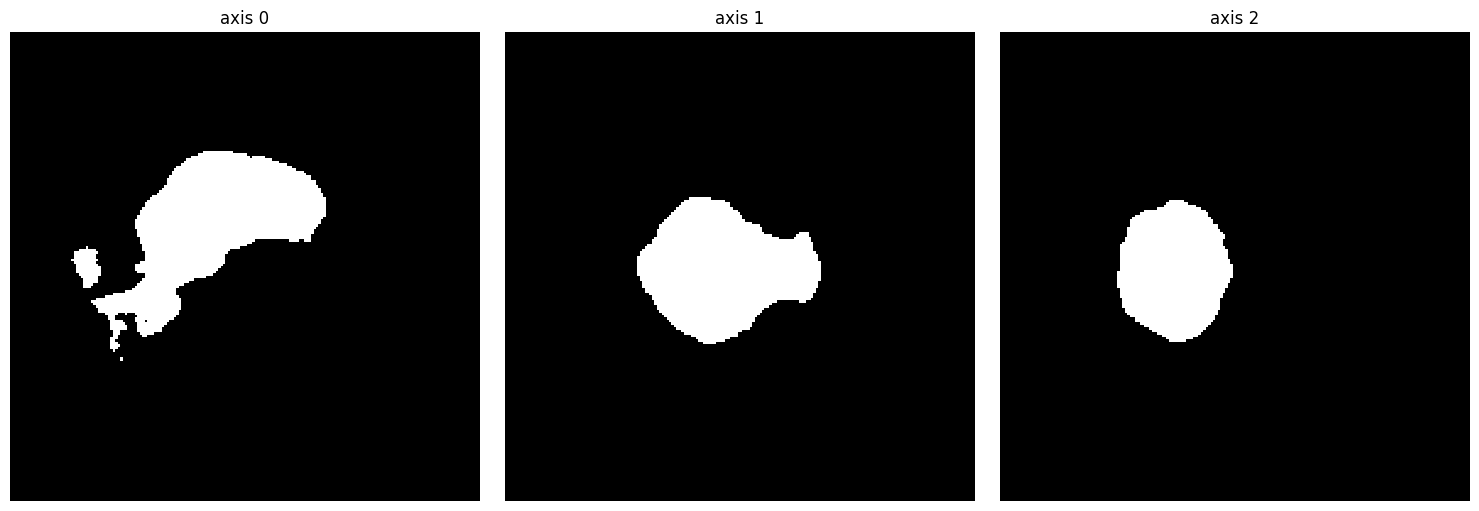

/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7778/anat/anat.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


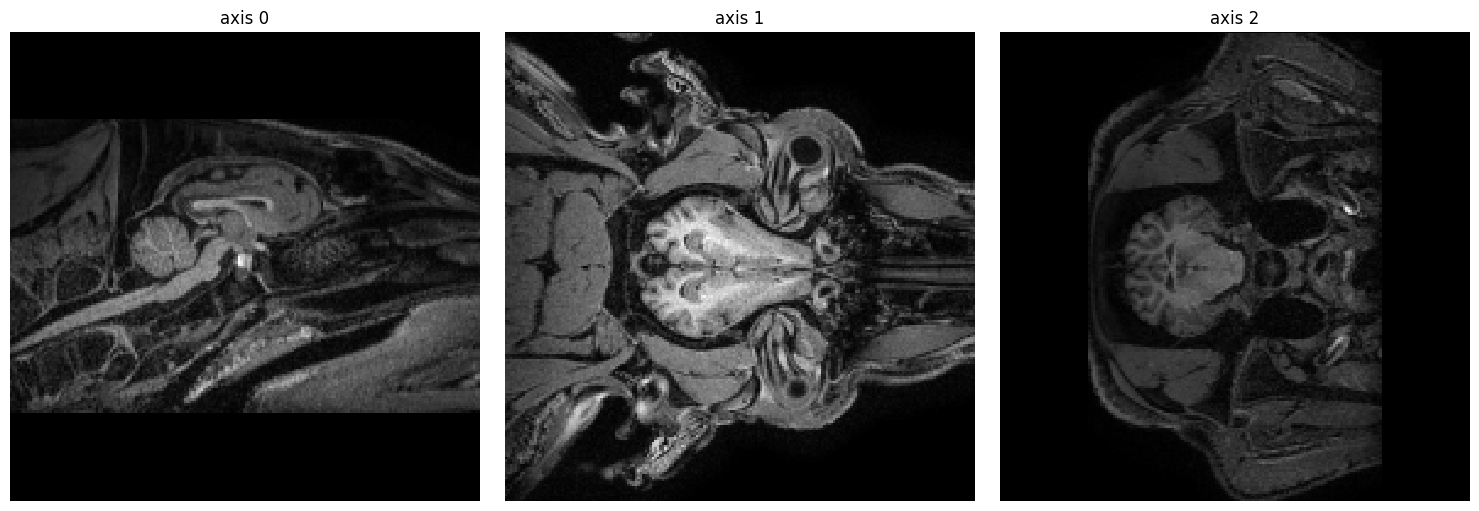

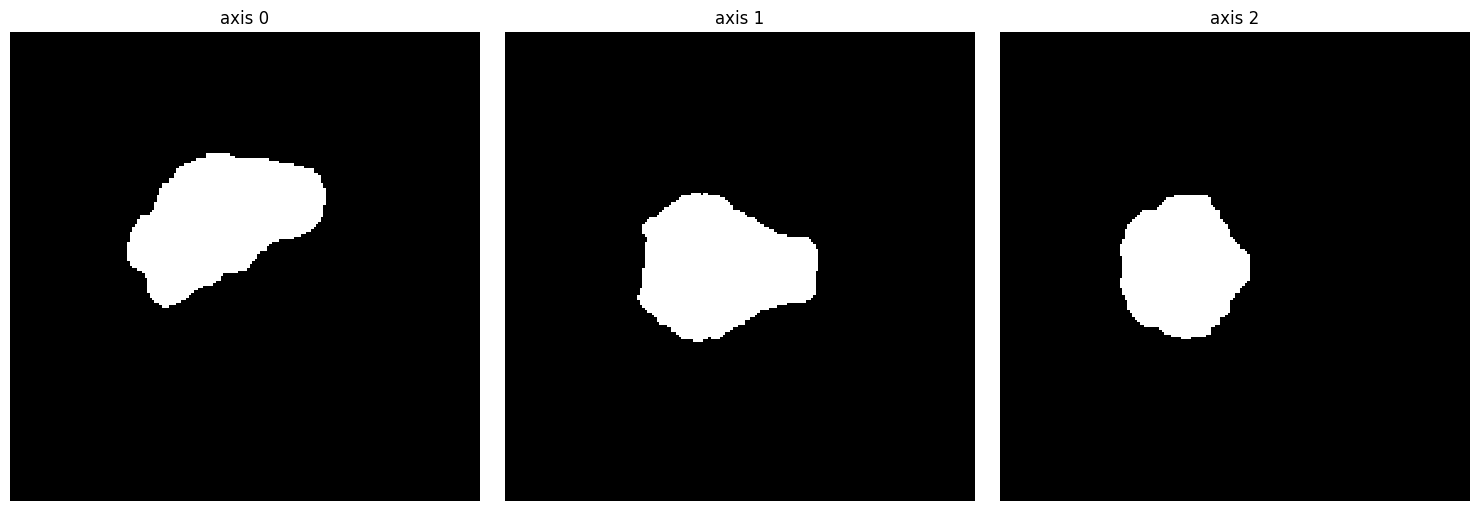

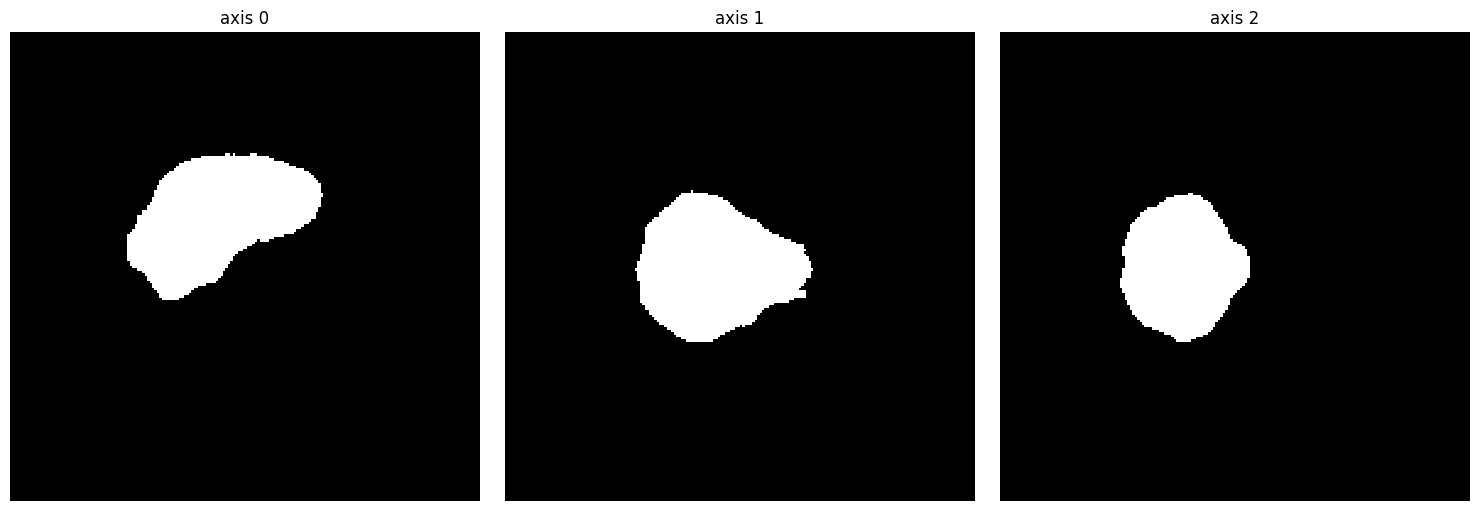

/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7665/anat/anat.nii.gz
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


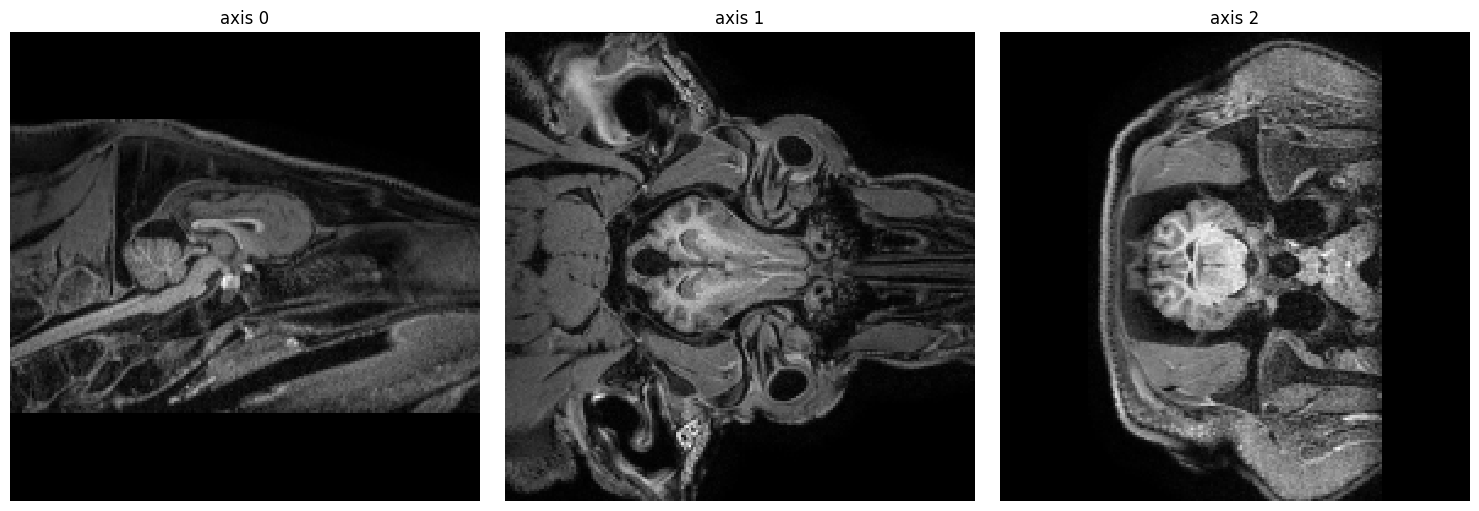

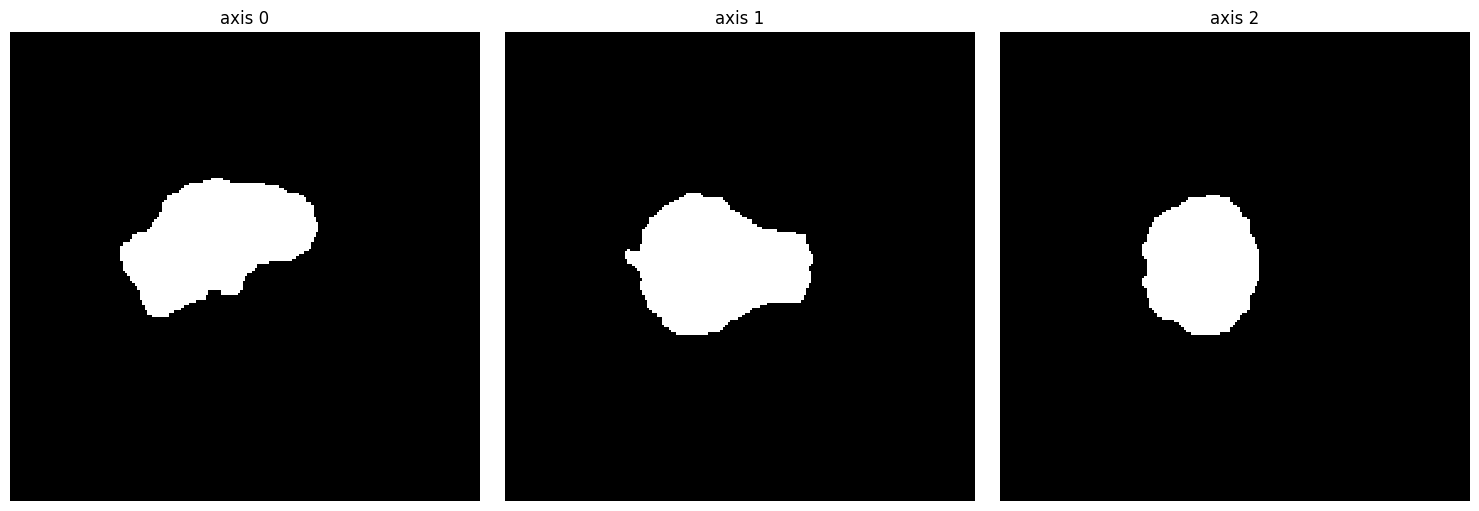

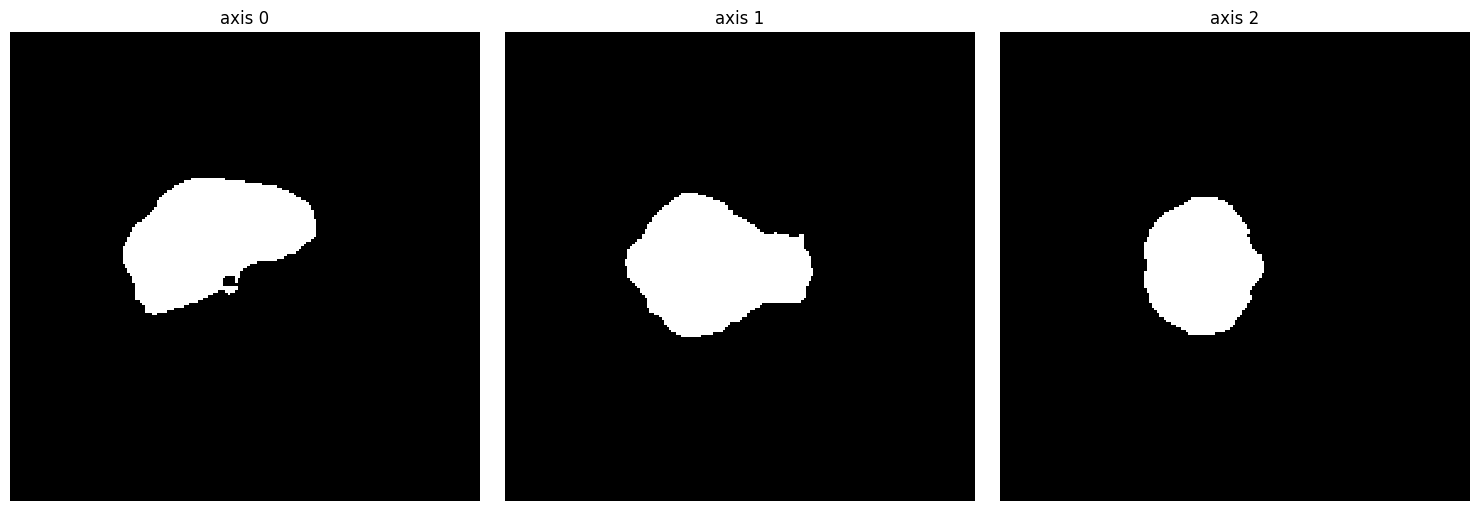

In [3]:
for folder in subfolders:
    folder_path = os.path.join(validation_folder_path, folder)
    filename = os.path.join(folder_path, "anat/anat.nii.gz")
    print(filename)
    mask_filename = os.path.join(folder_path, "anat/anat_brain_mask.nii.gz")

    image = sf.load_volume(filename)
    new_voxsize = [1,1,1]
    orig_voxsize = image.geom.voxsize
    crop_img = image.resize(new_voxsize, method="linear").reshape([192,192,192,1])
        
    mask = sf.load_volume(mask_filename).resize(new_voxsize, method="linear")
    mask = mask.resize(new_voxsize).reshape([192, 192, 192, 1])
    mask.data[mask.data != 0] = 1

    ms = np.mean(np.column_stack(np.nonzero(mask)), axis=0).astype(int)
    
    ne.plot.volume3D(crop_img, slice_nos=ms)
    ne.plot.volume3D(mask, slice_nos=ms)

    
    prediction_one_hot = combined_model.predict(crop_img[None,...], verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)[0]

    labeled, num_components = ndimage.label(prediction > 0)  # Label the connected components
    largest_mask = labeled == np.argmax(ndimage.sum(prediction > 0, labeled, range(num_components + 1)))  # Mask for the largest component
    ne.plot.volume3D(largest_mask, slice_nos=ms)
